In [3]:
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys
import shutil
import pickle
import seaborn as sns
sns.set_style('whitegrid')

In [19]:
from keras.models import Model, Sequential, load_model
from keras import optimizers, losses, callbacks, regularizers
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler, Callback
import tensorflow as tf
import matplotlib.pyplot as plt

# Load Data

In [5]:
element_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu']
df_train = pd.read_csv('../Data/oqmd_train.csv')
df_test = pd.read_csv('../Data/oqmd_test.csv')

## Convert string representation of molecular formula to one-hot encoding

In [6]:
def counts2vector(pairs):
    vec = [0]*len(element_list)
    for pair in pairs:
        vec[element_list.index(pair[0])]+=int(pair[1])
    vec = np.array(vec)
    return vec

def onehot(enc):
    rep = np.zeros((len(element_list),11))
    rep[:,0] = 1
    for i,val in enumerate(enc):
        if val!=0:
            rep[i][0]=0
            rep[i][val]=1
    return rep.flatten()

def encode(df):
    formulae = df[['comp']]
    counts = pd.Series(formulae.values.flatten()).str.findall(r"([a-z]+)([0-9]+)", re.I)
    df['encoding'] = counts.apply(counts2vector)
    df['onehot'] = df['encoding'].apply(onehot)

In [7]:
encode(df_train)
encode(df_test)

## Extract the encoding and target values

In [8]:
X_train = df_train.onehot.values
X_train = np.stack(X_train,axis=0)
X_test = df_test.onehot.values
X_test = np.stack(X_test,axis=0)
y_train = df_train[['delta_e','volume_pa','energy_pa']].values
y_test = df_test[['delta_e','volume_pa','energy_pa']].values

# Generator model - DING

## Encoder

In [24]:
n_z = 32  # dimension of latent space
n_x = X_train.shape[1] 
n_y = y_train.shape[1]

X = Input(shape=(n_x,))
cond = Input(shape=(n_y,))

inputs = Concatenate(axis=1)([X,cond])
h_q = Dense(512, activation='relu')(inputs)
h_q1= Dense(256, activation='relu')(h_q)
h_q2= Dense(128, activation='relu')(h_q1)
mu = Dense(n_z, activation='linear')(h_q2)
log_sigma = Dense(n_z, activation='linear')(h_q2)

## Function to sample points in the latent space

In [25]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(n_z,), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2.) * eps

## Loss Function

In [26]:
def vae_loss(y_true, y_pred):
    
    # Reconstruction Loss
    y_true_reshaped=tf.reshape(y_true,[-1,89,11])
    recon = 10 * K.mean(K.sum(K.categorical_crossentropy(y_true_reshaped, y_pred, axis=2),axis=1))

    # KL Divergence Loss
    kl = 0.05 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    
    #Total loss
    return recon + kl

## Decoder

In [27]:
z = Lambda(sample_z)([mu, log_sigma])
z_cond = Concatenate(axis=1)([z, cond])

decoder_hidden = Dense(128, activation='relu')
decoder_hidden_1 = Dense(256, activation='relu')
decoder_hidden_2 = Dense(512, activation='relu')
decoder_out = Dense(n_x, activation='linear')
decoder_out_act = Lambda(lambda x: K.softmax(K.reshape(x,(-1,89,11)), axis=2))

h_p = decoder_hidden(z_cond)
h_p1=decoder_hidden_1(h_p)
h_p2=decoder_hidden_2(h_p1)

outputs = decoder_out_act(decoder_out(h_p2))

## Overall CVAE for training

In [ ]:
vae = Model([X,cond], outputs)
vae.summary()

## Decoder and Encoder Models

In [29]:
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model([X,cond], mu)

# Generator model, generate new data given latent variable z
d_cond = Input(shape=(n_y,))
d_z = Input(shape=(n_z,))
d_inputs = Concatenate(axis=1)([d_z,d_cond])
d_h = decoder_hidden(d_inputs)
d_h1 = decoder_hidden_1(d_h)
d_h2 = decoder_hidden_2(d_h1)
d_out = decoder_out_act(decoder_out(d_h2))
decoder = Model([d_z,d_cond], d_out)

# Training

In [30]:
vae.compile(optimizer='adam', loss=vae_loss)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00000001,verbose=1)

## Checkpointing and Logging

In [31]:
class DecoderSaveCheckpoint(Callback):
    def __init__(self, filepath, decoder):
        self.monitor = 'val_loss'
        self.monitor_op = np.less
        self.best = np.Inf

        self.filepath = filepath
        self.decoder = decoder

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.monitor_op(current, self.best):
            self.best = current
            self.decoder.save(self.filepath, overwrite=True)

In [32]:
losses=[]
checkpoint=callbacks.ModelCheckpoint(filepath='ding_model_best.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
save_loss = callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: [
        losses.append(logs['val_loss'])])

In [ ]:
vae.fit([X_train, y_train], X_train, batch_size=256, epochs=150, validation_split=0.2,callbacks=[reduce_lr,checkpoint,save_loss, DecoderSaveCheckpoint('ding_decoder_best.h5', decoder)])

In [34]:
np.min(losses)

6.700931416377322

## Plot training and validation loss

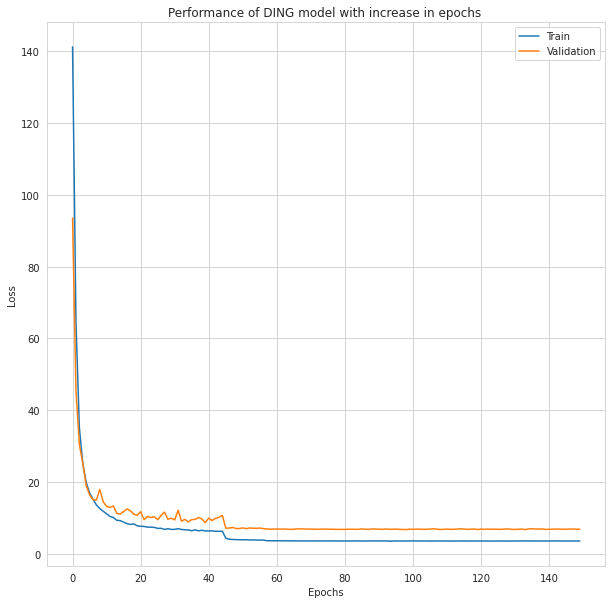

In [35]:
plt.figure(figsize=(10,10))
plt.plot(vae.history.history['loss'])
plt.plot(vae.history.history['val_loss'])
plt.title("Performance of DING model with increase in epochs ")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

# Find reconstruction accuracy

In [36]:
Y_pred = vae.predict([X_test,y_test])
Y_pred = Y_pred.reshape(-1,89,11)

In [37]:
pred_encoding = np.zeros((Y_pred.shape[0],89))
Y_pred[Y_pred<0.5]=0

for i,mol in enumerate(Y_pred):
    for j,atom in enumerate(mol):
        if atom.max()!=0:
            pred_encoding[i][j] = atom.argmax()

test_encoding = np.zeros_like(pred_encoding)
for i,mol in enumerate(X_test.reshape(-1,89,11)):
    for j,atom in enumerate(mol):
        if atom.max()!=0:
            test_encoding[i][j] = atom.argmax()

In [38]:
accuracy = (np.unique(np.sum(np.abs(pred_encoding - test_encoding),axis=1),return_counts=True))[1]*100/len(X_test)
print(accuracy)

[9.50417172e+01 1.78998052e+00 1.18719447e+00 4.55765060e-01
 4.41062962e-01 2.24207006e-01 2.49935678e-01 1.24967839e-01
 1.13941265e-01 7.35104936e-02 9.18881170e-02 4.04307715e-02
 5.14573455e-02 2.20531481e-02 2.94041974e-02 2.20531481e-02
 1.47020987e-02 1.83776234e-02 3.67552468e-03 3.67552468e-03]
